# Limpieza de datos

In [158]:
# Importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default')

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

En este notebook se tratará de limpiar los datos en lo que respecta a outliers. Sabemos que tanto el set de train como el de test no tienen nulos, pero en las features numericas no sabemos si algunos valores pueden estar fuera del grueso de la distribucion.

In [159]:
df_train_labels = pd.read_csv('../data/train_labels.csv', low_memory=False)
df_train_values = pd.read_csv('../data/train_values.csv', low_memory=False)
df_test = pd.read_csv('../data/test_values.csv', index_col='building_id', low_memory=False)
df_train = pd.merge(df_train_labels, df_train_values, how='inner', on='building_id')
df_train.set_index('building_id', inplace=True)

In [160]:
# Creo columna de damage_grade = -1 como dummy para poder juntar los 2 datasets
df_test['damage_grade'] = -1
df_test.head(1)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,-1


In [161]:
df_train.head(1)

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0


In [162]:
train_test = df_train.append(df_test, ignore_index=False, sort=False)
train_test.shape

(347469, 39)

In [163]:
train_test.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
28830,2,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
94947,3,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
590882,2,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
201944,3,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


En particular, usamos el metodo de boxplot con su intercuantil. Si un valor es mayor a 3 \* IQR por arriba del Q3, el valor es considerado un outlier. Al mismo tiempo, si un valor es menor a 3 \* IQR por abajo de Q1, entonces el valor va a ser considerado un outlier.

> https://www.listendata.com/2015/01/detecting-and-solving-problem-of-outlier.html

In [164]:
def eliminar_outliers_segun_iqr(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    h = 3 * iqr
    # Reemplazamos los outliers
    df.loc[df[feature] > q3 + h, feature] = q3 + h
    df.loc[df[feature] < q1 - h, feature] = q1 - h

## Verificando outliers

### count_floors_pre_eq

In [165]:
train_test['count_floors_pre_eq'].value_counts()

2    209029
3     74171
1     53705
4      7186
5      3039
6       283
7        52
8         3
9         1
Name: count_floors_pre_eq, dtype: int64

In [166]:
train_test['count_floors_pre_eq'].describe()

count             347,469.00
mean                    2.13
std                     0.73
min                     1.00
25%                     2.00
50%                     2.00
75%                     2.00
max                     9.00
Name: count_floors_pre_eq, dtype: float64

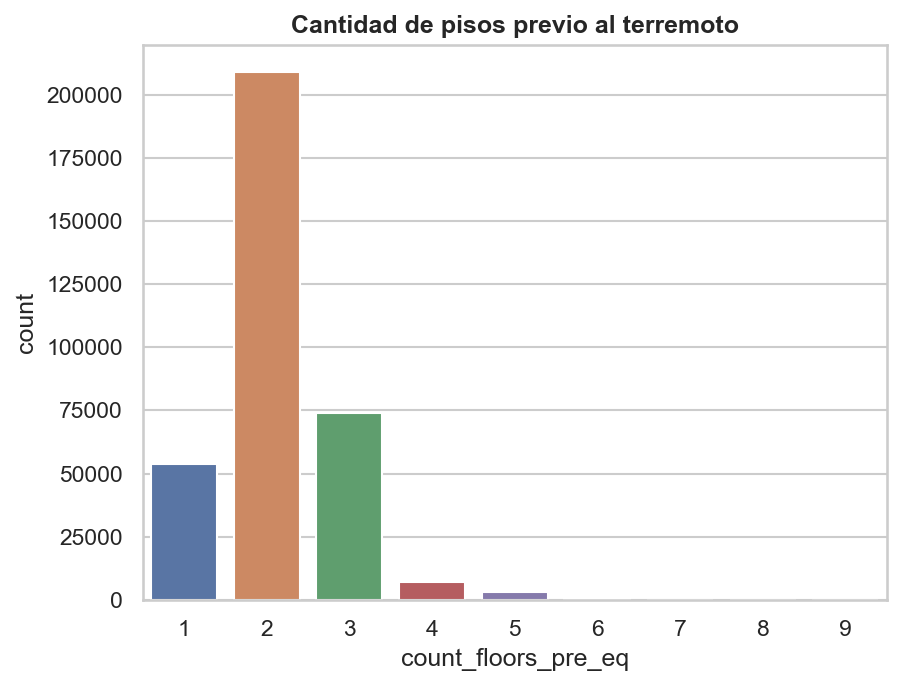

In [167]:
plt.figure(dpi=150)
sns.countplot(train_test['count_floors_pre_eq'])
plt.title("Cantidad de pisos previo al terremoto", weight='bold')
plt.show()

In [168]:
train_test['count_floors_pre_eq'].describe()

count             347,469.00
mean                    2.13
std                     0.73
min                     1.00
25%                     2.00
50%                     2.00
75%                     2.00
max                     9.00
Name: count_floors_pre_eq, dtype: float64

In [169]:
train_test.loc[(train_test['count_floors_pre_eq'] > 3), 'count_floors_pre_eq'] = 3

In [170]:
train_test['count_floors_pre_eq'].describe()

count             347,469.00
mean                    2.09
std                     0.62
min                     1.00
25%                     2.00
50%                     2.00
75%                     2.00
max                     3.00
Name: count_floors_pre_eq, dtype: float64

### Age

In [171]:
train_test['age'].value_counts()

10     51680
15     48074
5      45045
20     42792
0      34725
25     32586
30     23977
35     14420
40     14050
50      9619
45      6255
60      4773
80      4087
55      2695
70      2679
100     1880
995     1851
65      1497
90      1426
85      1133
75       693
95       547
120      236
150      179
110      142
200      140
105      119
125       62
115       30
130       13
140       11
180       11
160        8
170        7
190        5
175        5
135        5
155        4
145        3
195        2
165        2
185        1
Name: age, dtype: int64

In [172]:
train_test['age'].describe()

count             347,469.00
mean                   26.54
std                    73.53
min                     0.00
25%                    10.00
50%                    15.00
75%                    30.00
max                   995.00
Name: age, dtype: float64

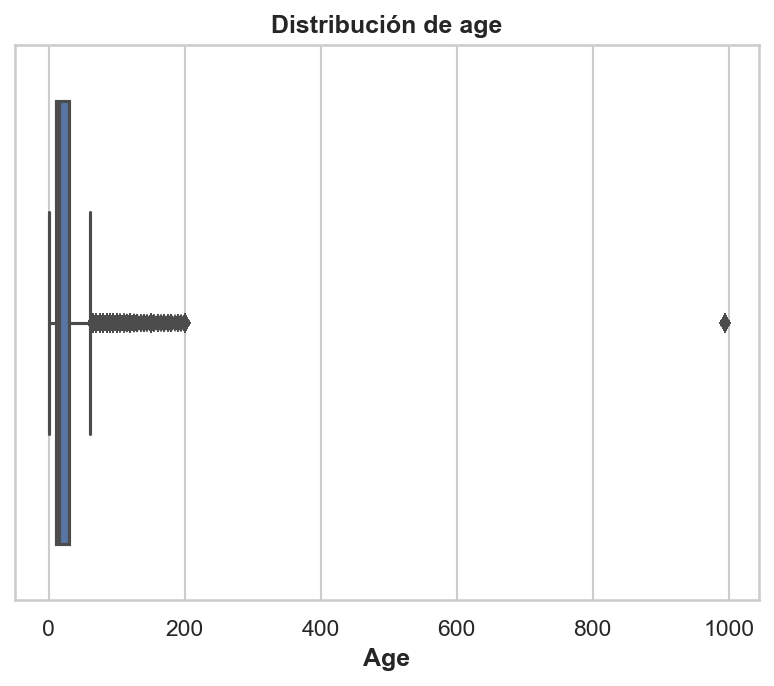

In [173]:
data = train_test['age']
plt.figure(dpi=150)
plt.title("Distribución de age - Antes", weight='bold')
sns.boxplot(data)
plt.xlabel('Age', weight='bold')
plt.show()

In [174]:
eliminar_outliers_segun_iqr(train_test, 'age')

In [175]:
train_test['age'].describe()

count             347,469.00
mean                   21.52
std                    19.29
min                     0.00
25%                    10.00
50%                    15.00
75%                    30.00
max                    90.00
Name: age, dtype: float64

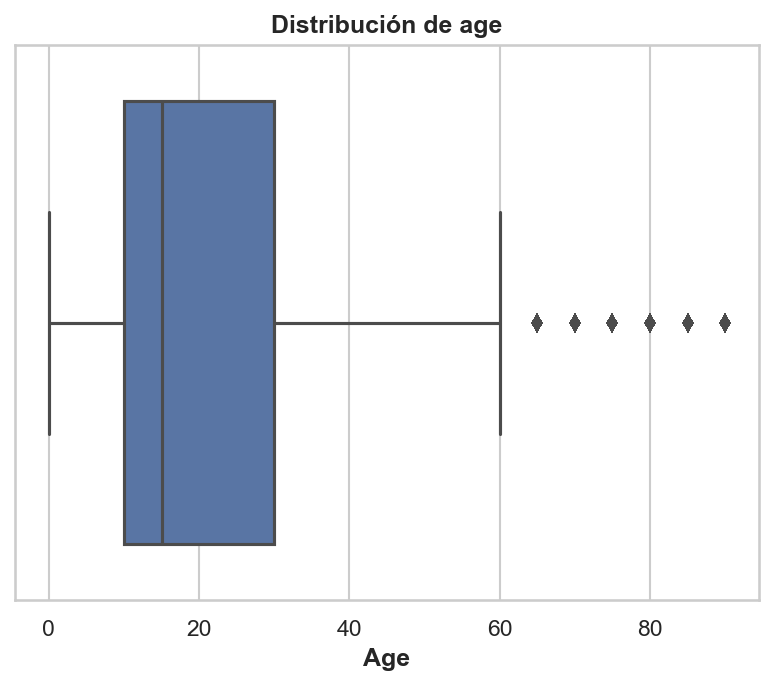

In [176]:
data = train_test['age']
plt.figure(dpi=150)
plt.title("Distribución de age - Despues", weight='bold')
sns.boxplot(data)
plt.xlabel('Age', weight='bold')
plt.show()

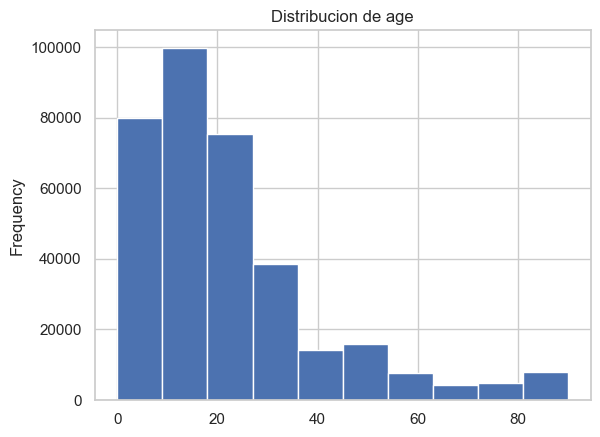

In [177]:
train_test['age'].plot(kind = 'hist', title='Distribucion de age - Despues')
plt.show()

### Area percentage

In [178]:
train_test['area_percentage'].value_counts()

6      55959
7      49140
5      43556
8      37988
9      29572
       ...  
75         1
90         1
82         1
100        1
81         1
Name: area_percentage, Length: 86, dtype: int64

In [179]:
train_test['area_percentage'].describe()

count             347,469.00
mean                    8.02
std                     4.39
min                     1.00
25%                     5.00
50%                     7.00
75%                     9.00
max                   100.00
Name: area_percentage, dtype: float64

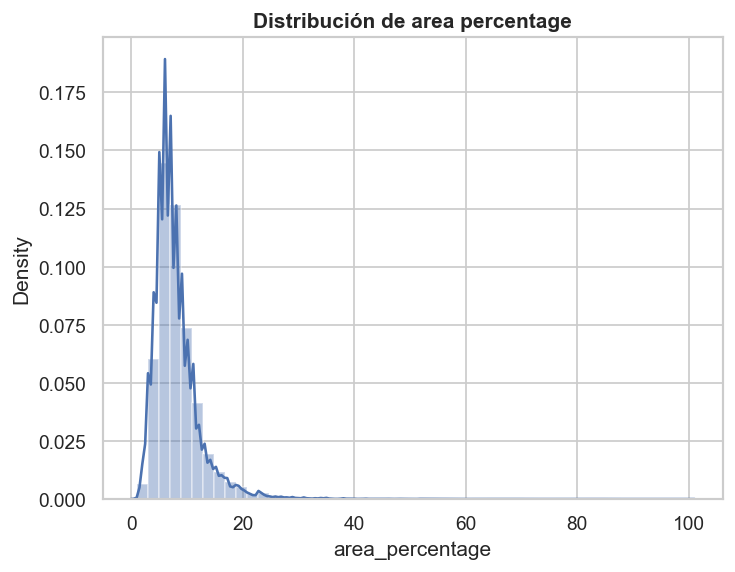

In [180]:
plt.figure(dpi=125)
sns.distplot(train_test['area_percentage'])
plt.title("Distribución de area percentage - antes", weight='bold')
plt.show()

In [181]:
eliminar_outliers_segun_iqr(train_test, 'area_percentage')
train_test['area_percentage'].describe()

count             347,469.00
mean                    7.90
std                     3.73
min                     1.00
25%                     5.00
50%                     7.00
75%                     9.00
max                    21.00
Name: area_percentage, dtype: float64

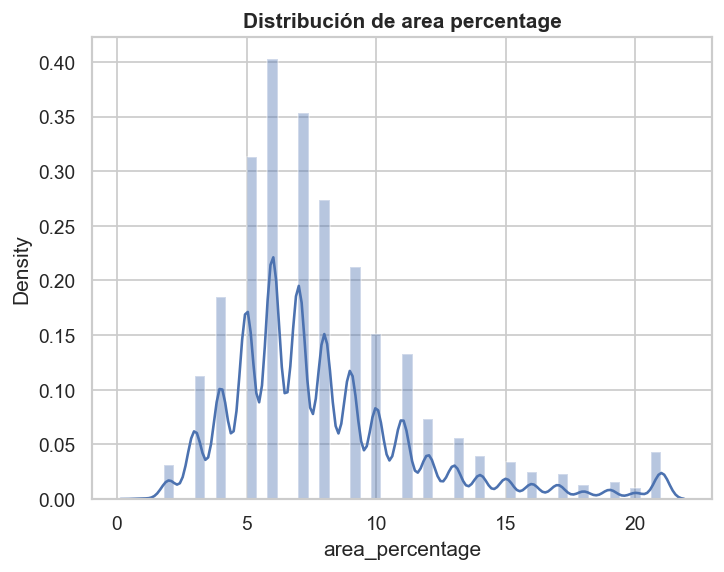

In [182]:
plt.figure(dpi=125)
sns.distplot(train_test['area_percentage'])
plt.title("Distribución de area percentage - despues", weight='bold')
plt.show()

### Height percentage

In [183]:
train_test['height_percentage'].value_counts()

5     104869
6      61837
4      50427
7      47360
3      34535
8      18460
2      12348
9       7146
10      5934
12      1246
11      1242
13      1036
15       399
16       246
18        95
32        90
14        85
20        41
21        21
23        12
17        11
19         8
24         6
25         4
26         3
22         3
28         2
31         2
29         1
Name: height_percentage, dtype: int64

In [184]:
train_test['height_percentage'].describe()

count             347,469.00
mean                    5.43
std                     1.92
min                     2.00
25%                     4.00
50%                     5.00
75%                     6.00
max                    32.00
Name: height_percentage, dtype: float64

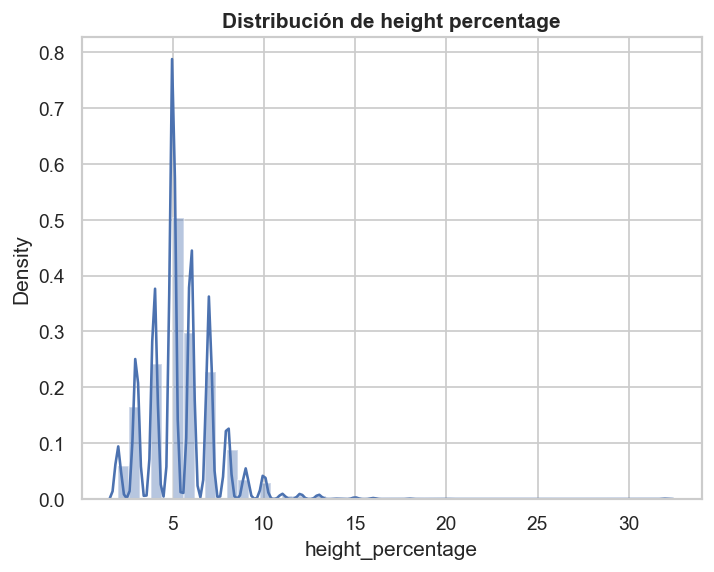

In [185]:
plt.figure(dpi=125)
sns.distplot(train_test['height_percentage'])
plt.title("Distribución de height percentage - antes", weight='bold')
plt.show()

In [186]:
eliminar_outliers_segun_iqr(train_test, 'height_percentage')
train_test['height_percentage'].describe()

count             347,469.00
mean                    5.42
std                     1.80
min                     2.00
25%                     4.00
50%                     5.00
75%                     6.00
max                    12.00
Name: height_percentage, dtype: float64

In [187]:
train_test['height_percentage'].value_counts()

5     104869
6      61837
4      50427
7      47360
3      34535
8      18460
2      12348
9       7146
10      5934
12      3311
11      1242
Name: height_percentage, dtype: int64

### Count families

In [188]:
train_test['count_families'].value_counts()

1    301377
0     27937
2     15010
3      2415
4       547
5       135
6        33
7         8
9         4
8         3
Name: count_families, dtype: int64

In [189]:
train_test['count_families'].describe()

count             347,469.00
mean                    0.98
std                     0.42
min                     0.00
25%                     1.00
50%                     1.00
75%                     1.00
max                     9.00
Name: count_families, dtype: float64

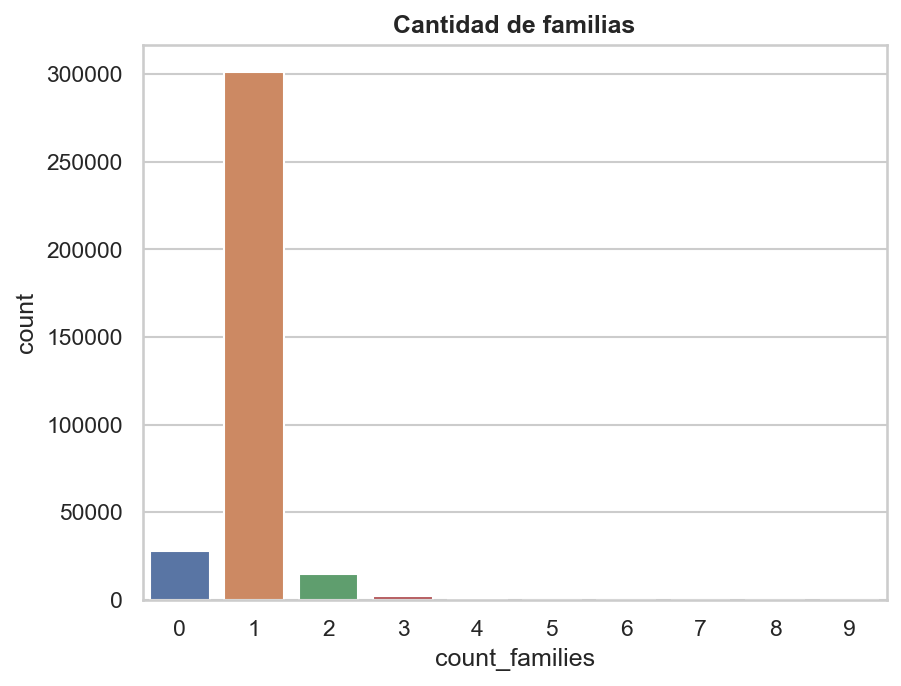

In [190]:
plt.figure(dpi=150)
sns.countplot(train_test['count_families'])
plt.title("Cantidad de familias - antes", weight='bold')
plt.show()

In [191]:
train_test.loc[(train_test['count_families'] > 3), 'count_families'] = 3
train_test['count_families'].value_counts()

1    301377
0     27937
2     15010
3      3145
Name: count_families, dtype: int64

### Guardando para posterior feature engineering

In [192]:
train = train_test[(train_test['damage_grade'] != -1)]
train.reset_index(inplace=True)
test = train_test[(train_test['damage_grade'] == -1)]
test.reset_index(inplace=True)

In [193]:
train.head()

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,3,6,487,12198,2,30,6,5,t,...,0,0,0,0,0,0,0,0,0,0
1,28830,2,8,900,2812,2,10,8,7,o,...,0,0,0,0,0,0,0,0,0,0
2,94947,3,21,363,8973,2,10,5,5,t,...,0,0,0,0,0,0,0,0,0,0
3,590882,2,22,418,10694,2,10,6,5,t,...,0,0,0,0,0,0,0,0,0,0
4,201944,3,11,131,1488,3,30,8,9,t,...,0,0,0,0,0,0,0,0,0,0


In [194]:
train.shape

(260601, 40)

In [195]:
test.head()

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,-1,17,596,11307,3,20,7,6,t,...,0,0,0,0,0,0,0,0,0,0
1,99355,-1,6,141,11987,2,25,13,5,t,...,1,0,0,0,0,0,0,0,0,0
2,890251,-1,22,19,10044,2,5,4,5,t,...,0,0,0,0,0,0,0,0,0,0
3,745817,-1,26,39,633,1,0,19,3,t,...,0,0,1,0,0,0,0,0,0,0
4,421793,-1,17,289,7970,3,15,8,7,t,...,0,0,0,0,0,0,0,0,0,0


In [196]:
del test['damage_grade']

In [197]:
test.shape

(86868, 39)

In [198]:
# Guardamos
train.to_csv('../data/train_cleaned.csv', index=False)
test.to_csv('../data/test_cleaned.csv', index=False)